# **Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Model, Sequential  # type: ignore
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences   # type: ignore
from tensorflow.keras.regularizers import l2    # type: ignore
from tensorflow.keras.optimizers import Adam    # type: ignore
import shap
import lime
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline

# **Linear Regression**

In [3]:
df = pd.read_excel(r"F:\University\Uni Stuff (semester 11)\Thesis\code\data\raw\thesis_excel (4).xlsx", parse_dates=['Crime date'])

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Age             2081 non-null   int64         
 1   Gender          2081 non-null   object        
 2   Crime Location  2081 non-null   object        
 3   PS/SD           2081 non-null   object        
 4   Crime date      2081 non-null   datetime64[ns]
 5   Crime time      2059 non-null   object        
 6   Allegation      2081 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 113.9+ KB
None
               Age                     Crime date
count  2081.000000                           2081
mean     44.902451  2024-05-16 04:39:33.474291200
min      19.000000            2024-01-02 00:00:00
25%      38.000000            2024-03-11 00:00:00
50%      45.000000            2024-05-17 00:00:00
75%      51.000000            2024-07-26 00:00:00


### **Pre-processing**

In [5]:
pre_processed_df = df.copy()
# pre_processed_df = df.drop_duplicates()

In [6]:
print(pre_processed_df.info())
print(pre_processed_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Age             2081 non-null   int64         
 1   Gender          2081 non-null   object        
 2   Crime Location  2081 non-null   object        
 3   PS/SD           2081 non-null   object        
 4   Crime date      2081 non-null   datetime64[ns]
 5   Crime time      2059 non-null   object        
 6   Allegation      2081 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 113.9+ KB
None
               Age                     Crime date
count  2081.000000                           2081
mean     44.902451  2024-05-16 04:39:33.474291200
min      19.000000            2024-01-02 00:00:00
25%      38.000000            2024-03-11 00:00:00
50%      45.000000            2024-05-17 00:00:00
75%      51.000000            2024-07-26 00:00:00


In [7]:
pre_processed_df.head(10)

,Age,Gender,Crime Location,PS/SD,Crime date,Crime time,Allegation
0,30,male,vulta,rupgonj,2024-01-02,06:00 am-08:59 am,drugs
1,32,male,vulta,rupgonj,2024-01-02,06:00 am-08:59 am,drugs
2,38,male,vulta,rupgonj,2024-01-02,06:00 am-08:59 am,drugs
3,32,male,vulta,rupgonj,2024-01-02,06:00 am-08:59 am,drugs
4,65,male,kala paharia,araihazar,2024-01-02,06:00 am-08:59 am,half murder
5,30,male,kala paharia,araihazar,2024-01-02,06:00 am-08:59 am,half murder
6,35,male,kala paharia,araihazar,2024-01-02,06:00 am-08:59 am,half murder
7,45,male,kala paharia,araihazar,2024-01-02,06:00 am-08:59 am,half murder
8,20,male,kala paharia,araihazar,2024-01-02,06:00 am-08:59 am,half murder
9,35,female,kala paharia,araihazar,2024-01-02,06:00 am-08:59 am,half murder


In [8]:
pre_processed_df.dtypes

Age                        int64
Gender                    object
Crime Location            object
PS/SD                     object
Crime date        datetime64[ns]
Crime time                object
Allegation                object
dtype: object

In [9]:
pre_processed_df.columns

Index(['Age', 'Gender', 'Crime Location', 'PS/SD', 'Crime date', 'Crime time',
       'Allegation'],
      dtype='object')

In [10]:
print(pre_processed_df.isnull().sum())

Age                0
Gender             0
Crime Location     0
PS/SD              0
Crime date         0
Crime time        22
Allegation         0
dtype: int64


In [11]:
pre_processed_df['Allegation'].unique()

array(['drugs', 'half murder', 'murder', 'extortion', 'robbery',
       'Unlawful Assembly Membership', 'Collective Criminal Liability',
       'theft', 'terror', 'life threat', 'arms supply',
       'explosive supply', 'ordered to murder', 'mob attack',
       'unethical gathering', 'attack', 'death threat', 'loss of value',
       'Cocktail explosion', 'Illegal gathering',
       'illegal arms possession', 'helped to deliver explosive',
       'illegal arms supply'], dtype=object)

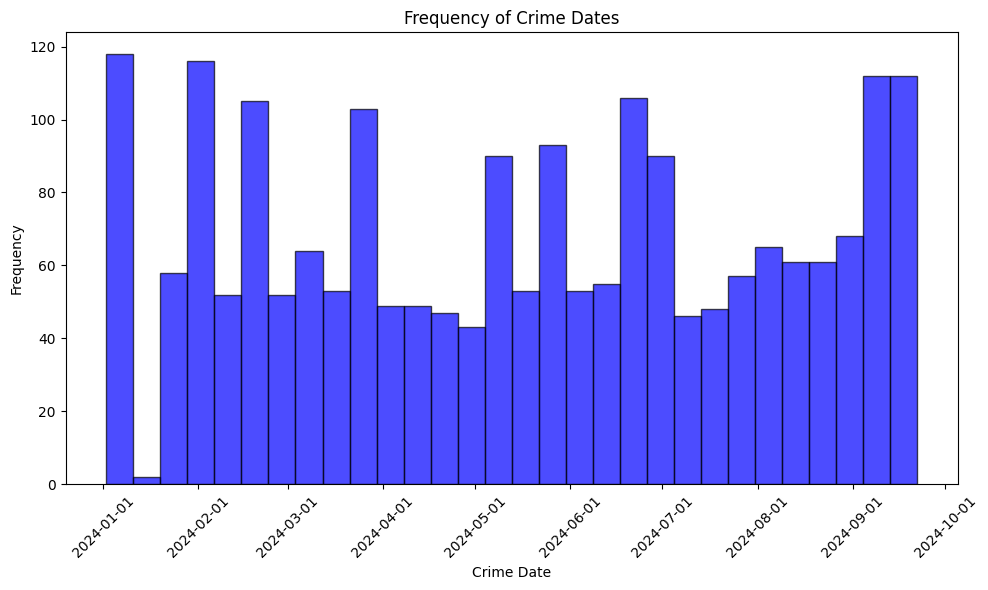

In [12]:
import matplotlib.dates as mdates
# Frequency plot of crime date
plt.figure(figsize=(10, 6))
plt.hist(pre_processed_df['Crime date'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Frequency of Crime Dates')
plt.xlabel('Crime Date')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot of Allegation
# plt.figure(figsize=(10, 6))
# plt.barh(pre_processed_df['Allegation'].value_counts().index, 
#         pre_processed_df['Allegation'].value_counts(), 
#         color='blue', alpha=0.4)
# plt.title('Frequency of Allegations')
# plt.xlabel('Allegation')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()

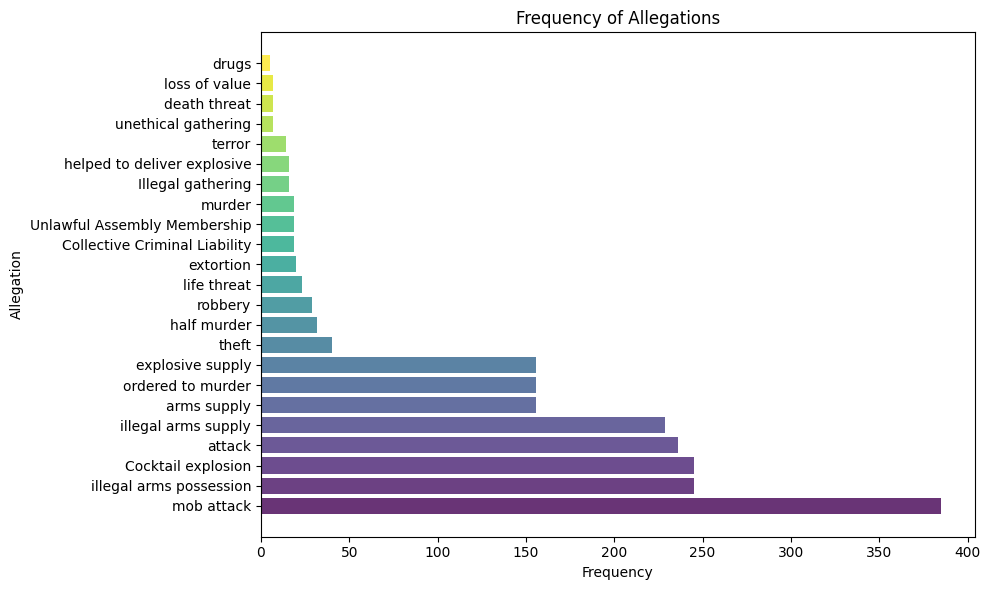

In [13]:
# Bar plot of Allegation
import matplotlib.cm as cm
allegation_counts = pre_processed_df['Allegation'].value_counts()
colors = cm.viridis(np.linspace(0, 1, len(allegation_counts)))
plt.figure(figsize=(10, 6))
plt.barh(allegation_counts.index, allegation_counts.values, color=colors, alpha=0.8)
plt.title('Frequency of Allegations')
plt.xlabel('Frequency')
plt.ylabel('Allegation')
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_7468\1196533779.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  months = pd.Series(bin_dates).pipe(pd.to_datetime).dt.to_period('M')


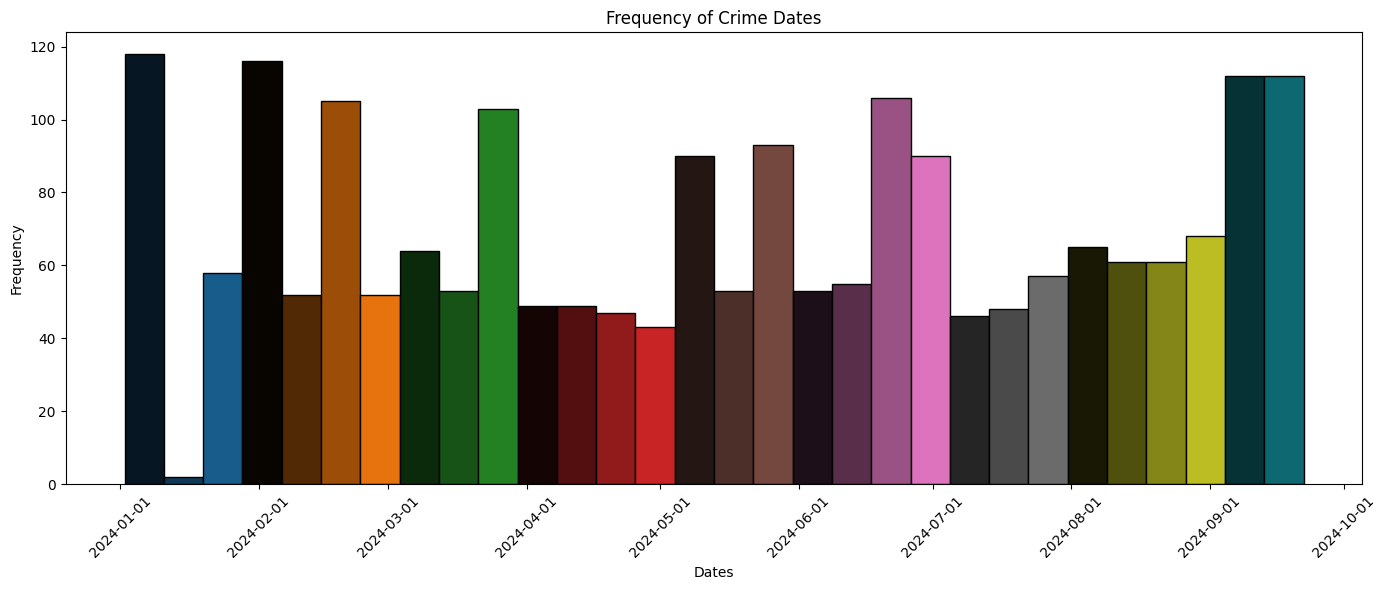

In [ ]:
from matplotlib.colors import to_rgba
pre_processed_df['Month'] = pre_processed_df['Crime date'].dt.to_period('M')

date_nums = mdates.date2num(pre_processed_df['Crime date'])

# Compute histogram
bin_count = 30
counts, bin_edges = np.histogram(date_nums, bins=bin_count)

# Midpoints for plotting bars
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Convert midpoints back to datetime
bin_dates = mdates.num2date(bin_centers)
bin_dates = pd.to_datetime(bin_dates)

# Assign color based on month and shade by day
months = pd.Series(bin_dates).pipe(pd.to_datetime).dt.to_period('M')
unique_months = months.unique()
base_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_months)))

bar_colors = []
for dt, mon in zip(bin_dates, months):
    base = base_colors[list(unique_months).index(mon)]
    shade = dt.day / 31
    rgba = to_rgba(base)
    bar_colors.append((rgba[0]*shade, rgba[1]*shade, rgba[2]*shade, 1.0))

widths = np.diff(bin_edges)
plt.figure(figsize=(14,6))
plt.bar(bin_dates, counts, width=widths, align='center',
        color=bar_colors, edgecolor='black')

plt.title('Frequency of Crime Dates')
plt.xlabel('Dates')
plt.ylabel('Frequency')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
pre_processed_df['Crime time'] = imputer.fit_transform(pre_processed_df[['Crime time']]).ravel()
# pre_processed_df = pre_processed_df.sort_values('Crime date', inplace=True)

NameError: name 'SimpleImputer' is not defined

In [13]:
pre_processed_df['Crime time'].unique()

array(['06:00 am-08:59 am', '12:00 pm-02:59 pm', '03:00 pm-5:59 pm',
       '09:00 am-11:59 am', '06:00 pm-08:59 pm', '09:00 pm-11:59 pm',
       '12:00 am-02:59 am', '03:00 am-5:59 am'], dtype=object)

In [ ]:
# Pivot the table to have one row per location-month, with columns for each event type
# df_wide = pre_processed_df.pivot_table(
#     index=["Crime Location", "Crime date"],
#     columns="Allegation",
#     # values="Events",
#     fill_value=0  # Fill missing events with 0
# ).reset_index()

In [15]:
agg = (pre_processed_df.groupby(["Crime date","Crime time","Crime Location"]).size().reset_index(name="crime count"))

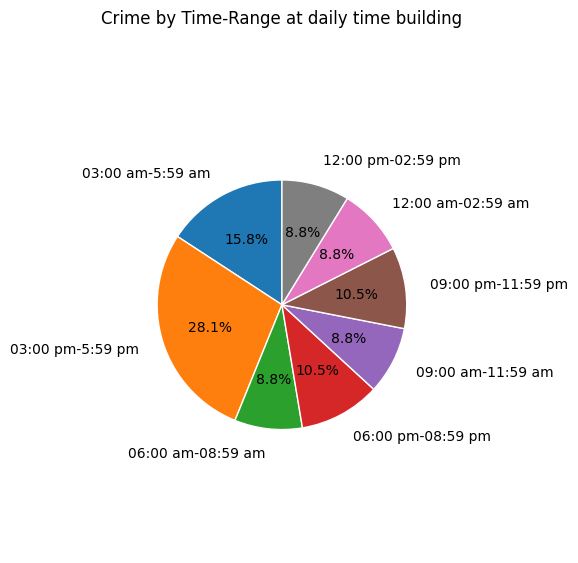

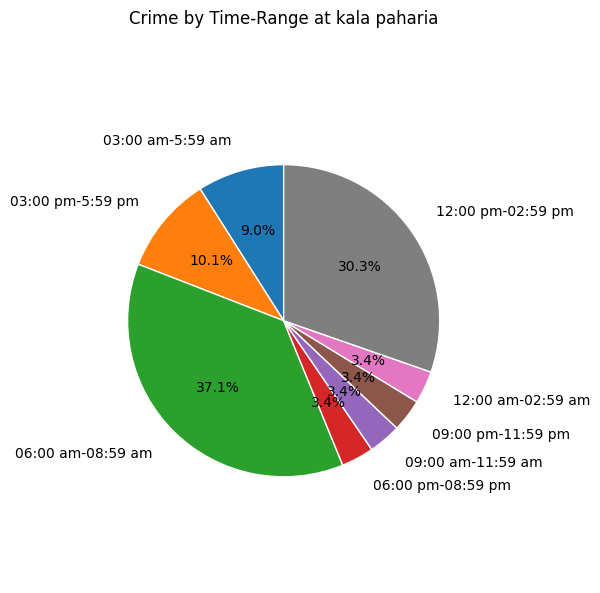

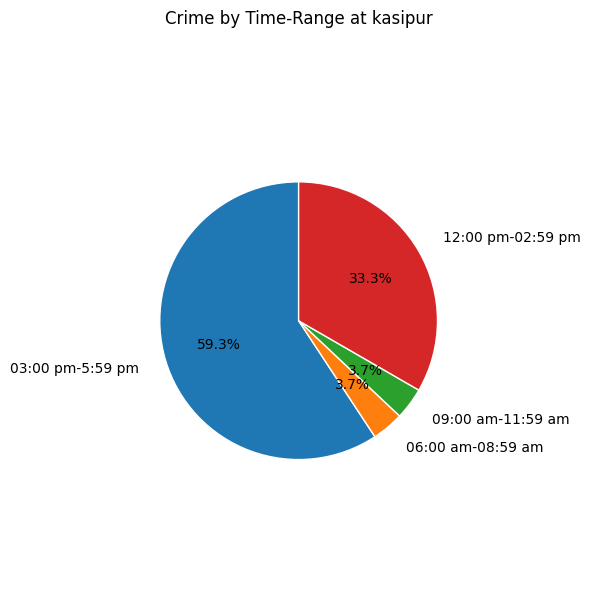

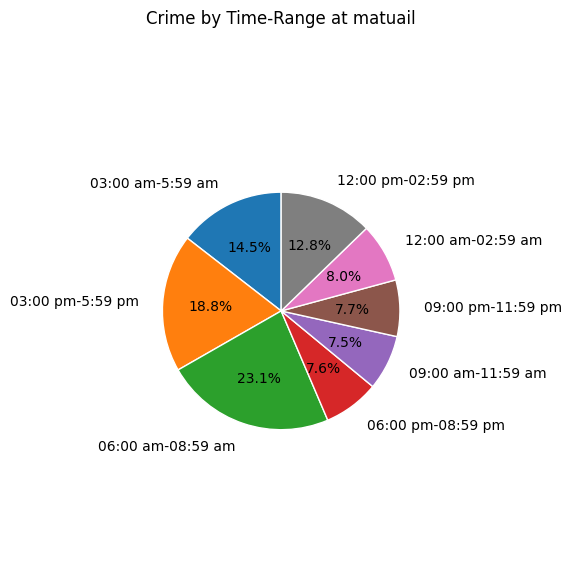

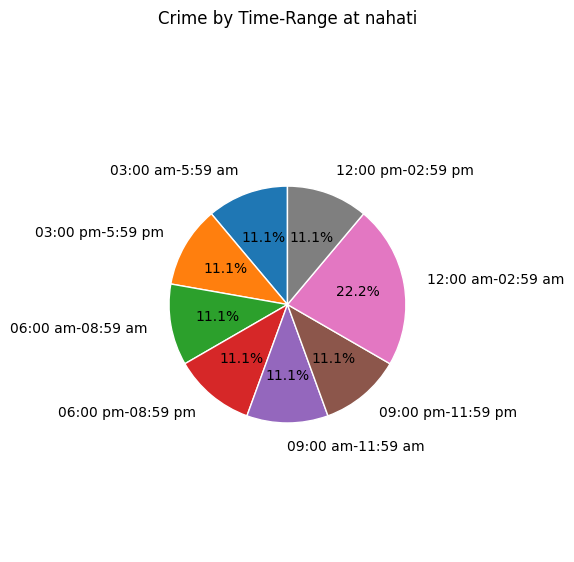

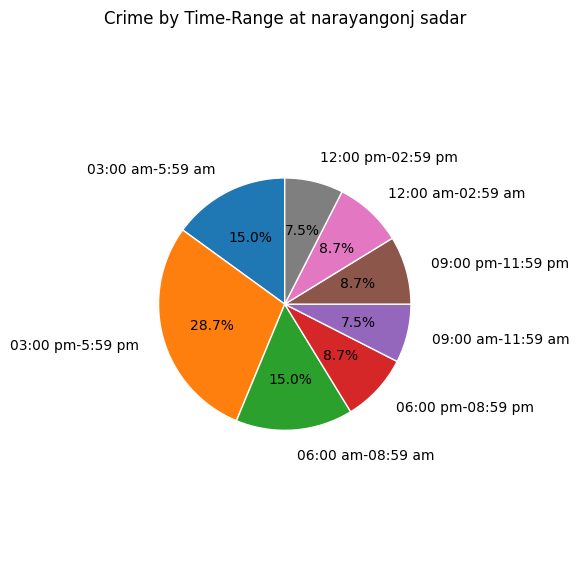

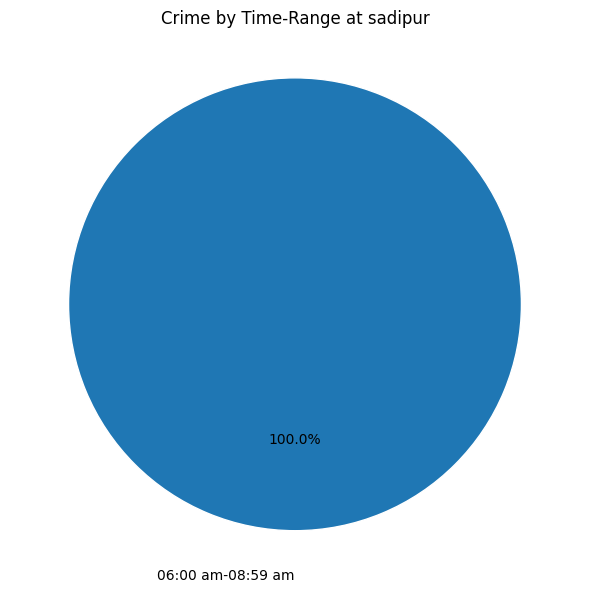

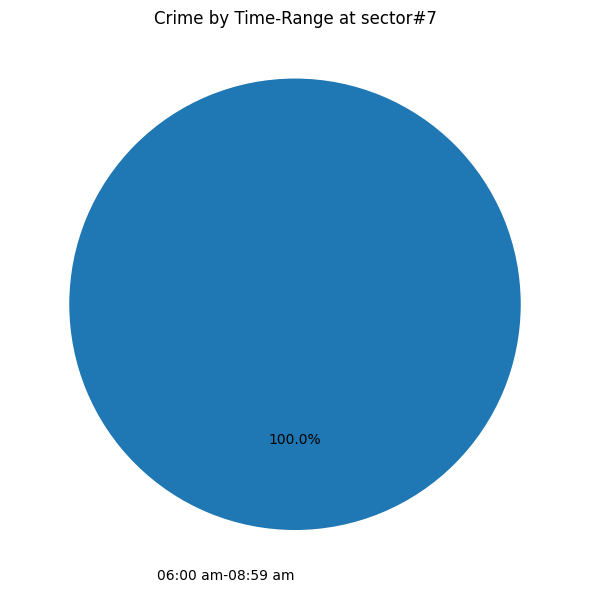

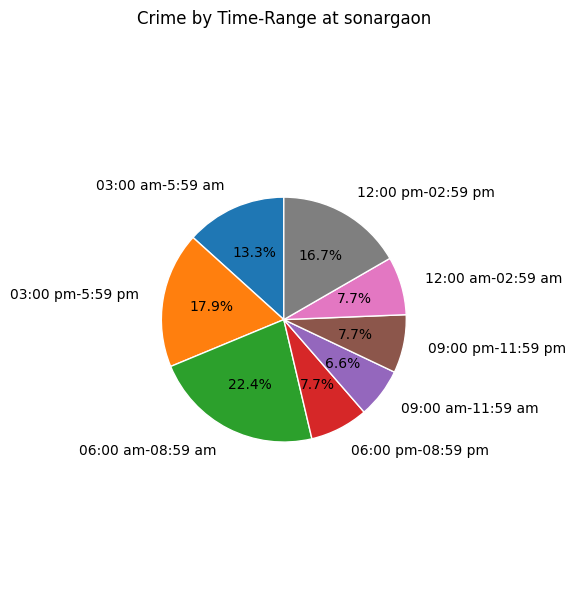

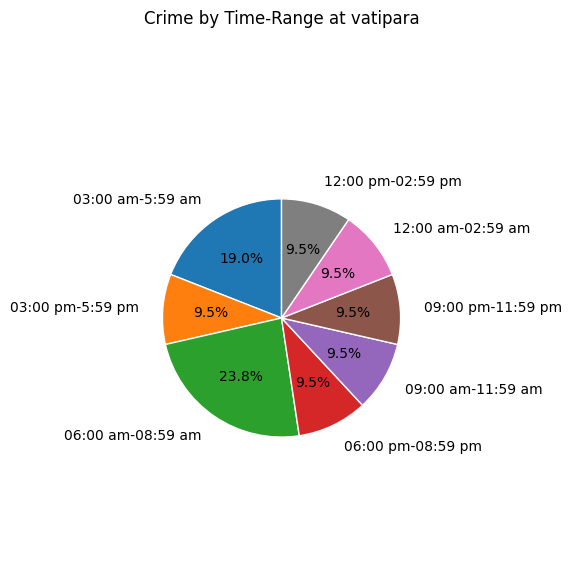

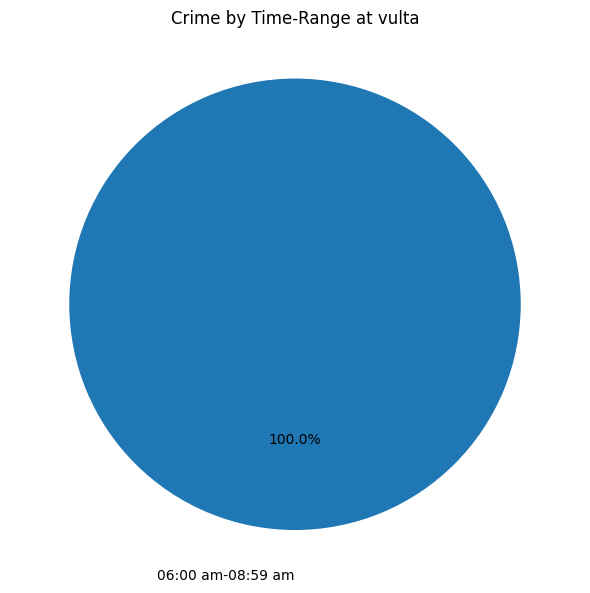

In [16]:
# compute total counts per (location, time_range)
totals = (
    agg
    .groupby(["Crime Location","Crime time"])["crime count"]
    .sum()
    .reset_index()
)

# for each location, pull out its time_range counts and plot a pie
locations_time_range = totals["Crime Location"].unique()
n = len(locations_time_range)
cols = 3
rows = (n + cols - 1) // cols

# fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
# axes = axes.flatten()

for loc in totals["Crime Location"].unique():
    df_loc = totals[totals["Crime Location"] == loc]
    sizes  = df_loc["crime count"].values
    labels = df_loc["Crime time"].values

    # new figure for this location, 6×6 inches
    plt.figure(figsize=(6, 6))

    # draw pie with larger radius and label-distance
    plt.pie(
        sizes,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        radius=1.2,             # makes the pie itself larger
        labeldistance=1.2,     # moves labels out a bit
        wedgeprops={"edgecolor": "w", "linewidth": 1}
    )

    plt.title(f"Crime by Time-Range at {loc}", y=1.05)
    plt.axis("equal")           # keep it circular
    plt.tight_layout()
    plt.show()
# for ax, loc in zip(axes, locations_time_range):
#     # select this location’s data
#     df_loc = totals[totals["Crime Location"] == loc]
#     sizes = df_loc["crime count"].values
#     labels = df_loc["Crime time"].values

#     plt.figure(figsize=(6, 6))
#     # draw pie
#     ax.pie(
#         sizes,
#         labels=labels,
#         autopct="%1.1f%%",
#         startangle=90,
#         radius=1.2,             # makes the pie itself larger
#         labeldistance=1.05,
#         wedgeprops={"edgecolor":"w", "linewidth": 1}
#     )
#     ax.set_title(f"Location: {loc}")

# for ax in axes[len(locations_time_range):]:
#     ax.axis("off")

# plt.title(f"Crime by Time-Range at {loc}", y=1.05)
# plt.axis("equal")           # keep it circular
# plt.tight_layout()
# plt.show()


In [17]:
# day-of-week, weekend flag, day-of-month, month, etc.
agg["day of week"] = agg["Crime date"].dt.weekday        # 0=Monday…6=Sunday
agg["is weekend"] = agg["day of week"].isin([5,6]).astype(int)
agg["day of month"] = agg["Crime date"].dt.day
agg["month"] = agg["Crime date"].dt.month

In [18]:
bin_order = ['06:00 am-08:59 am', '09:00 am-11:59 am', '12:00 pm-02:59 pm', 
             '03:00 pm-5:59 pm','06:00 pm-08:59 pm', '09:00 pm-11:59 pm',
            '12:00 am-02:59 am', '03:00 am-5:59 am']

bin_map = {b:i for i,b in enumerate(bin_order)}
agg["time bin"] = agg["Crime time"].map(bin_map)

In [19]:
# agg = pd.get_dummies(agg, columns=["Crime Location"], prefix="loc")
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(agg[["Crime Location"]])
encoded_cols = encoder.get_feature_names_out(["Crime Location"])
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=agg.index)
agg = pd.concat([agg, encoded_df], axis=1)

In [ ]:
# label_encoder = LabelEncoder()
# agg['Crime Location'] = label_encoder.fit_transform(agg['Crime Location'])

In [132]:
# Create a complete date range for each location
# date_range = pd.date_range(start=pre_processed_df["Event month"].min(), end=pre_processed_df["Event month"].max(), freq="MS")  # "MS" = month start
# locations = pre_processed_df["Location"].unique()
# full_index = pd.MultiIndex.from_product([locations, date_range], names=["Location", "Event month"])

# # Reindex to fill missing months with zeros
# df_wide = df_wide.set_index(["Location", "Event month"]).reindex(full_index, fill_value=0).reset_index()

### **Feature Engineering**

In [20]:
agg = agg.sort_values(["Crime Location", "Crime time", "Crime date"])

# for each (location,time_range), compute prior-day count, 7-day rolling mean, etc.
agg["lag1"] = (agg.groupby(["Crime Location","Crime time"])["crime count"].shift(1))
# agg["lag2"] = (agg.groupby(["Crime Location","Crime time"])["crime count"].shift(2))
# agg["lag3"] = (agg.groupby(["Crime Location","Crime time"])["crime count"].shift(3))
agg["rolling7"] = (agg.groupby(["Crime Location","Crime time"])["crime count"].transform(lambda x: x.shift(1).rolling(7).mean()))
agg["rolling3"] = (agg.groupby(["Crime Location","Crime time"])["crime count"].transform(lambda x: x.shift(1).rolling(3).mean()))
agg[["lag1", "rolling3", "rolling7"]] = agg[["lag1", "rolling3","rolling7"]].fillna(agg[["lag1", "rolling3", "rolling7"]].mean())
# agg.drop(columns=["Crime Location"], inplace=True)

In [26]:
# agg.drop(columns=["Crime Location"], inplace=True)
agg.drop(columns=["rolling3"], inplace=True)

In [21]:
agg = agg.sort_values("Crime date")

In [22]:
feature_cols = [col for col in agg.columns if col not in ("Crime time", "Crime date", "crime count", "Crime Location")]
X = agg[feature_cols]
y = agg["crime count"]

In [56]:
# X.drop(columns=["Crime Location"], inplace=True)

In [57]:
# df_wide["Month"] = df_wide["Event month"].dt.month  # Extract month (1-12)
# df_wide["Month_sin"] = np.sin(2 * np.pi * df_wide["Month"] / 12)
# df_wide["Month_cos"] = np.cos(2 * np.pi * df_wide["Month"] / 12)

In [58]:
# event_types = pre_processed_df['Event Type'].unique()

# # Lag features for autoregressive modeling
# for cols in event_types:
#     df_wide[f"{cols}_Lag1"] = df_wide.groupby("Location")[cols].shift(1)

# # 12-month rolling average
# for cols in event_types:
#     df_wide[f"{cols}_Rolling12"] = df_wide.groupby("Location")[cols].transform(lambda x: x.rolling(12).mean())

In [59]:
# df_wide.fillna(0, inplace=True)

In [60]:
# df_wide['Total_crimes'] = df_wide[event_types].sum(axis=1)

# # Get all lag features (columns ending with _Lag{number})
# lag_features = [col for col in df_wide.columns if re.match(r'.+_Lag\d+', col)]

# # Get all rolling features (columns ending with _Rolling{number})
# rolling_features = [col for col in df_wide.columns if re.match(r'.+_Rolling\d+', col)]

# features = ["Month_sin", "Month_cos"] + lag_features + rolling_features

In [61]:
# print(df_wide.columns)
# print(features)

In [23]:
# Train/test split by date to avoid leakage
boundary = pd.to_datetime("2024-07-30")
train_idx = agg["Crime date"] <= boundary
test_idx  = agg["Crime date"] >  boundary
print(f"Train size: {train_idx.sum()}, Test size: {test_idx.sum()}")

Train size: 276, Test size: 60


In [ ]:
# X_train, X_test = X[train_idx], X[test_idx]
# y_train, y_test = y[train_idx], y[test_idx]

In [24]:
print(X.columns)
print(feature_cols)

Index(['day of week', 'is weekend', 'day of month', 'month', 'time bin',
       'Crime Location_daily time building', 'Crime Location_kala paharia',
       'Crime Location_kasipur', 'Crime Location_matuail',
       'Crime Location_nahati', 'Crime Location_narayangonj sadar',
       'Crime Location_sadipur', 'Crime Location_sector#7',
       'Crime Location_sonargaon', 'Crime Location_vatipara',
       'Crime Location_vulta', 'lag1', 'rolling7', 'rolling3'],
      dtype='object')
['day of week', 'is weekend', 'day of month', 'month', 'time bin', 'Crime Location_daily time building', 'Crime Location_kala paharia', 'Crime Location_kasipur', 'Crime Location_matuail', 'Crime Location_nahati', 'Crime Location_narayangonj sadar', 'Crime Location_sadipur', 'Crime Location_sector#7', 'Crime Location_sonargaon', 'Crime Location_vatipara', 'Crime Location_vulta', 'lag1', 'rolling7', 'rolling3']


In [31]:
# Fit RF to get importances
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)

# Pick top K (e.g. top 10) or threshold
topK = 10
selected_feats = importances.iloc[:topK].index.tolist()
X_sel = X[selected_feats]
print("Top features:\n", importances.head(topK))

Top features:
 rolling3                       0.215064
lag1                           0.184936
time bin                       0.176348
day of month                   0.148673
rolling7                       0.069564
day of week                    0.065878
month                          0.050540
Crime Location_sonargaon       0.025215
Crime Location_kala paharia    0.015073
Crime Location_matuail         0.012359
dtype: float64


In [32]:
X_train, X_test = X_sel[train_idx], X_sel[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²:   {r2:.3f}")

Test RMSE: 4.738
Test R²:   0.223


In [ ]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled  = scaler.transform(X_test)

In [34]:
print("Mean crime_count:", agg["crime count"].mean())
print("Std  crime_count:", agg["crime count"].std())

Mean crime_count: 6.193452380952381
Std  crime_count: 5.249143667258185


In [127]:
# feature_cols = [c for c in agg.columns if c not in ("Crime date","Crime time","crime count")]
# X = agg[feature_cols]
# y = agg["crime count"]

# pipe = Pipeline([
#     ("scaler", StandardScaler()),
#     ("lr", LinearRegression())
# ])

# tscv = TimeSeriesSplit(n_splits=40)
# scores = cross_val_score(pipe, X, y, cv=tscv, scoring="neg_root_mean_squared_error")
# print("5-fold CV RMSE:", -scores.mean(), "±", scores.std())

In [ ]:
# r2_scores = cross_val_score(pipe, X, y, cv=tscv, scoring="r2")
# print("5-fold CV R²:", r2_scores.mean(), "±", r2_scores.std())

5-fold CV R²: -1.2521669823421626 ± 2.3153972707250197


In [ ]:
# target = "Total_crimes"

# # Split data chronologically (e.g., train on 2019-2023, test on 2024-2025)
# train = df_wide[df_wide["Event month"] < "2024-01-01"]
# test = df_wide[df_wide["Event month"] >= "2024-01-01"]

# # Train model
# model = LinearRegression()
# model.fit(train[features], train[target])

# # Predict and evaluate
# predictions = model.predict(test[features])
# mae = mean_absolute_error(test[target], predictions)
# rmse = np.sqrt(mean_squared_error(test[target], predictions))
# r2 = r2_score(test[target], predictions)
# print(f"MAE: {mae:.2f}")
# print(f"RMSE: {rmse:.2f}")
# print(f"R²: {r2:.2f}")

MAE: 15.64
RMSE: 27.00
R²: 0.66


### **Model Evaluation**

In [35]:
agg_crime_count_mean = agg["crime count"].mean()
print(f"RMSE/mean: Error of {(rmse/agg_crime_count_mean)*100:.2f}% of the average crime count")
print(f"Variance explained: {r2*100:.2f}%")

RMSE/mean: Error of 76.50% of the average crime count
Variance explained: 22.28%


In [ ]:
# # Print coefficients and intercept
# coefficients = pd.DataFrame({
#     "Feature": features,
#     "Coefficient": model.coef_
# })
# intercept = pd.DataFrame({
#     "Feature": ["Intercept"],
#     "Coefficient": [model.intercept_]
# })
# coefficients_df = pd.concat([intercept, coefficients], ignore_index=True)

# print("Model Coefficients:")
# print(coefficients_df)

Model Coefficients:
                                 Feature  Coefficient
0                              Intercept     1.531646
1                              Month_sin    -0.750673
2                              Month_cos     2.576552
3                          Protests_Lag1     0.357236
4        Violence against civilians_Lag1     1.397174
5        Explosions/Remote violence_Lag1    -0.774308
6            Strategic developments_Lag1     2.100404
7                           Battles_Lag1    -2.996285
8                             Riots_Lag1     0.003849
9                     Protests_Rolling12     0.654531
10  Violence against civilians_Rolling12    -0.961698
11  Explosions/Remote violence_Rolling12    -4.717033
12      Strategic developments_Rolling12     2.374265
13                     Battles_Rolling12   -10.448895
14                       Riots_Rolling12     1.265625


### **Plotting**

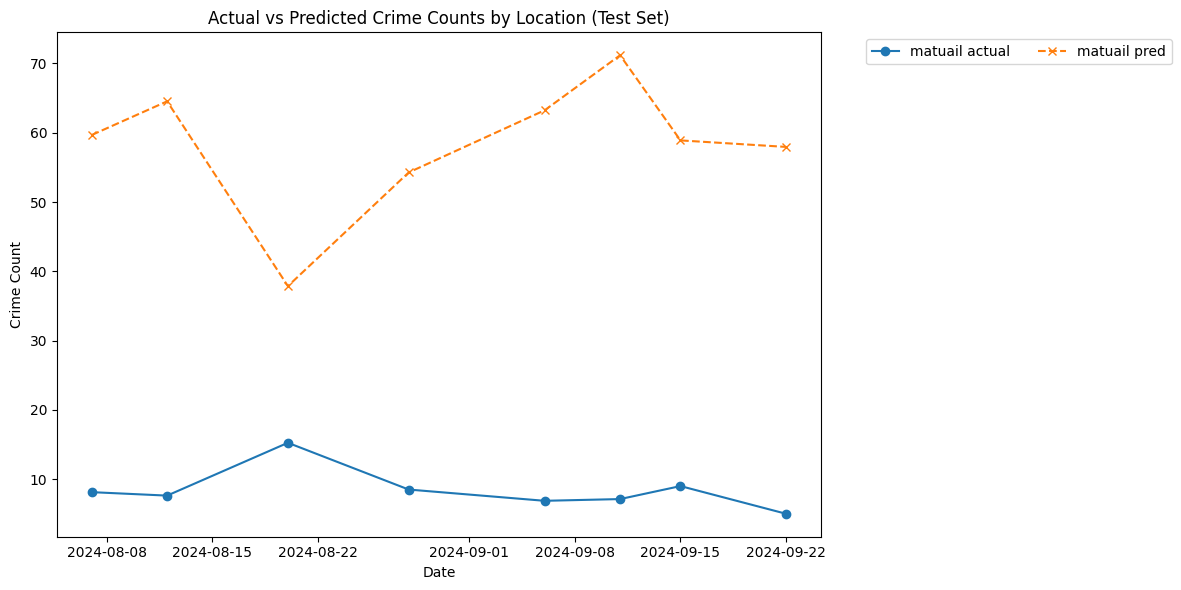

In [35]:
grid = agg.copy()
X_test_grid = grid.loc[test_idx, feature_cols]

# assign back into a new column, only for test rows
grid.loc[test_idx, "predicted_count"] = y_pred
grid.loc[test_idx, "actual_count"] = grid.loc[test_idx, "crime count"]

# subset to test‐only DataFrame
test_grid = grid.loc[test_idx]

# pivot test_grid so rows are dates and columns are locations
pivot_test = (test_grid.pivot_table
        (
         index="Crime date",
         columns="Crime Location",
         values="predicted_count",
         aggfunc="sum"    # or "sum" 
        ).fillna(0))

pivot_actual = (grid.loc[test_idx].pivot_table
                (index="Crime date", 
                 columns="Crime Location", 
                 values="actual_count", 
                 aggfunc="mean"
                ).fillna(0))

plt.figure(figsize=(12, 6))
for loc in pivot_actual.columns:
    # actual in solid line
    plt.plot(pivot_actual.index, pivot_actual[loc], marker="o", label=f"{loc} actual")
    # predicted in dashed line
    plt.plot(pivot_test.index,   pivot_test[loc],   marker="x", linestyle="--", label=f"{loc} pred")

plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.title("Actual vs Predicted Crime Counts by Location (Test Set)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_688\1468398295.py:33: UserWarning: The figure layout has changed to tight
  g.figure.t

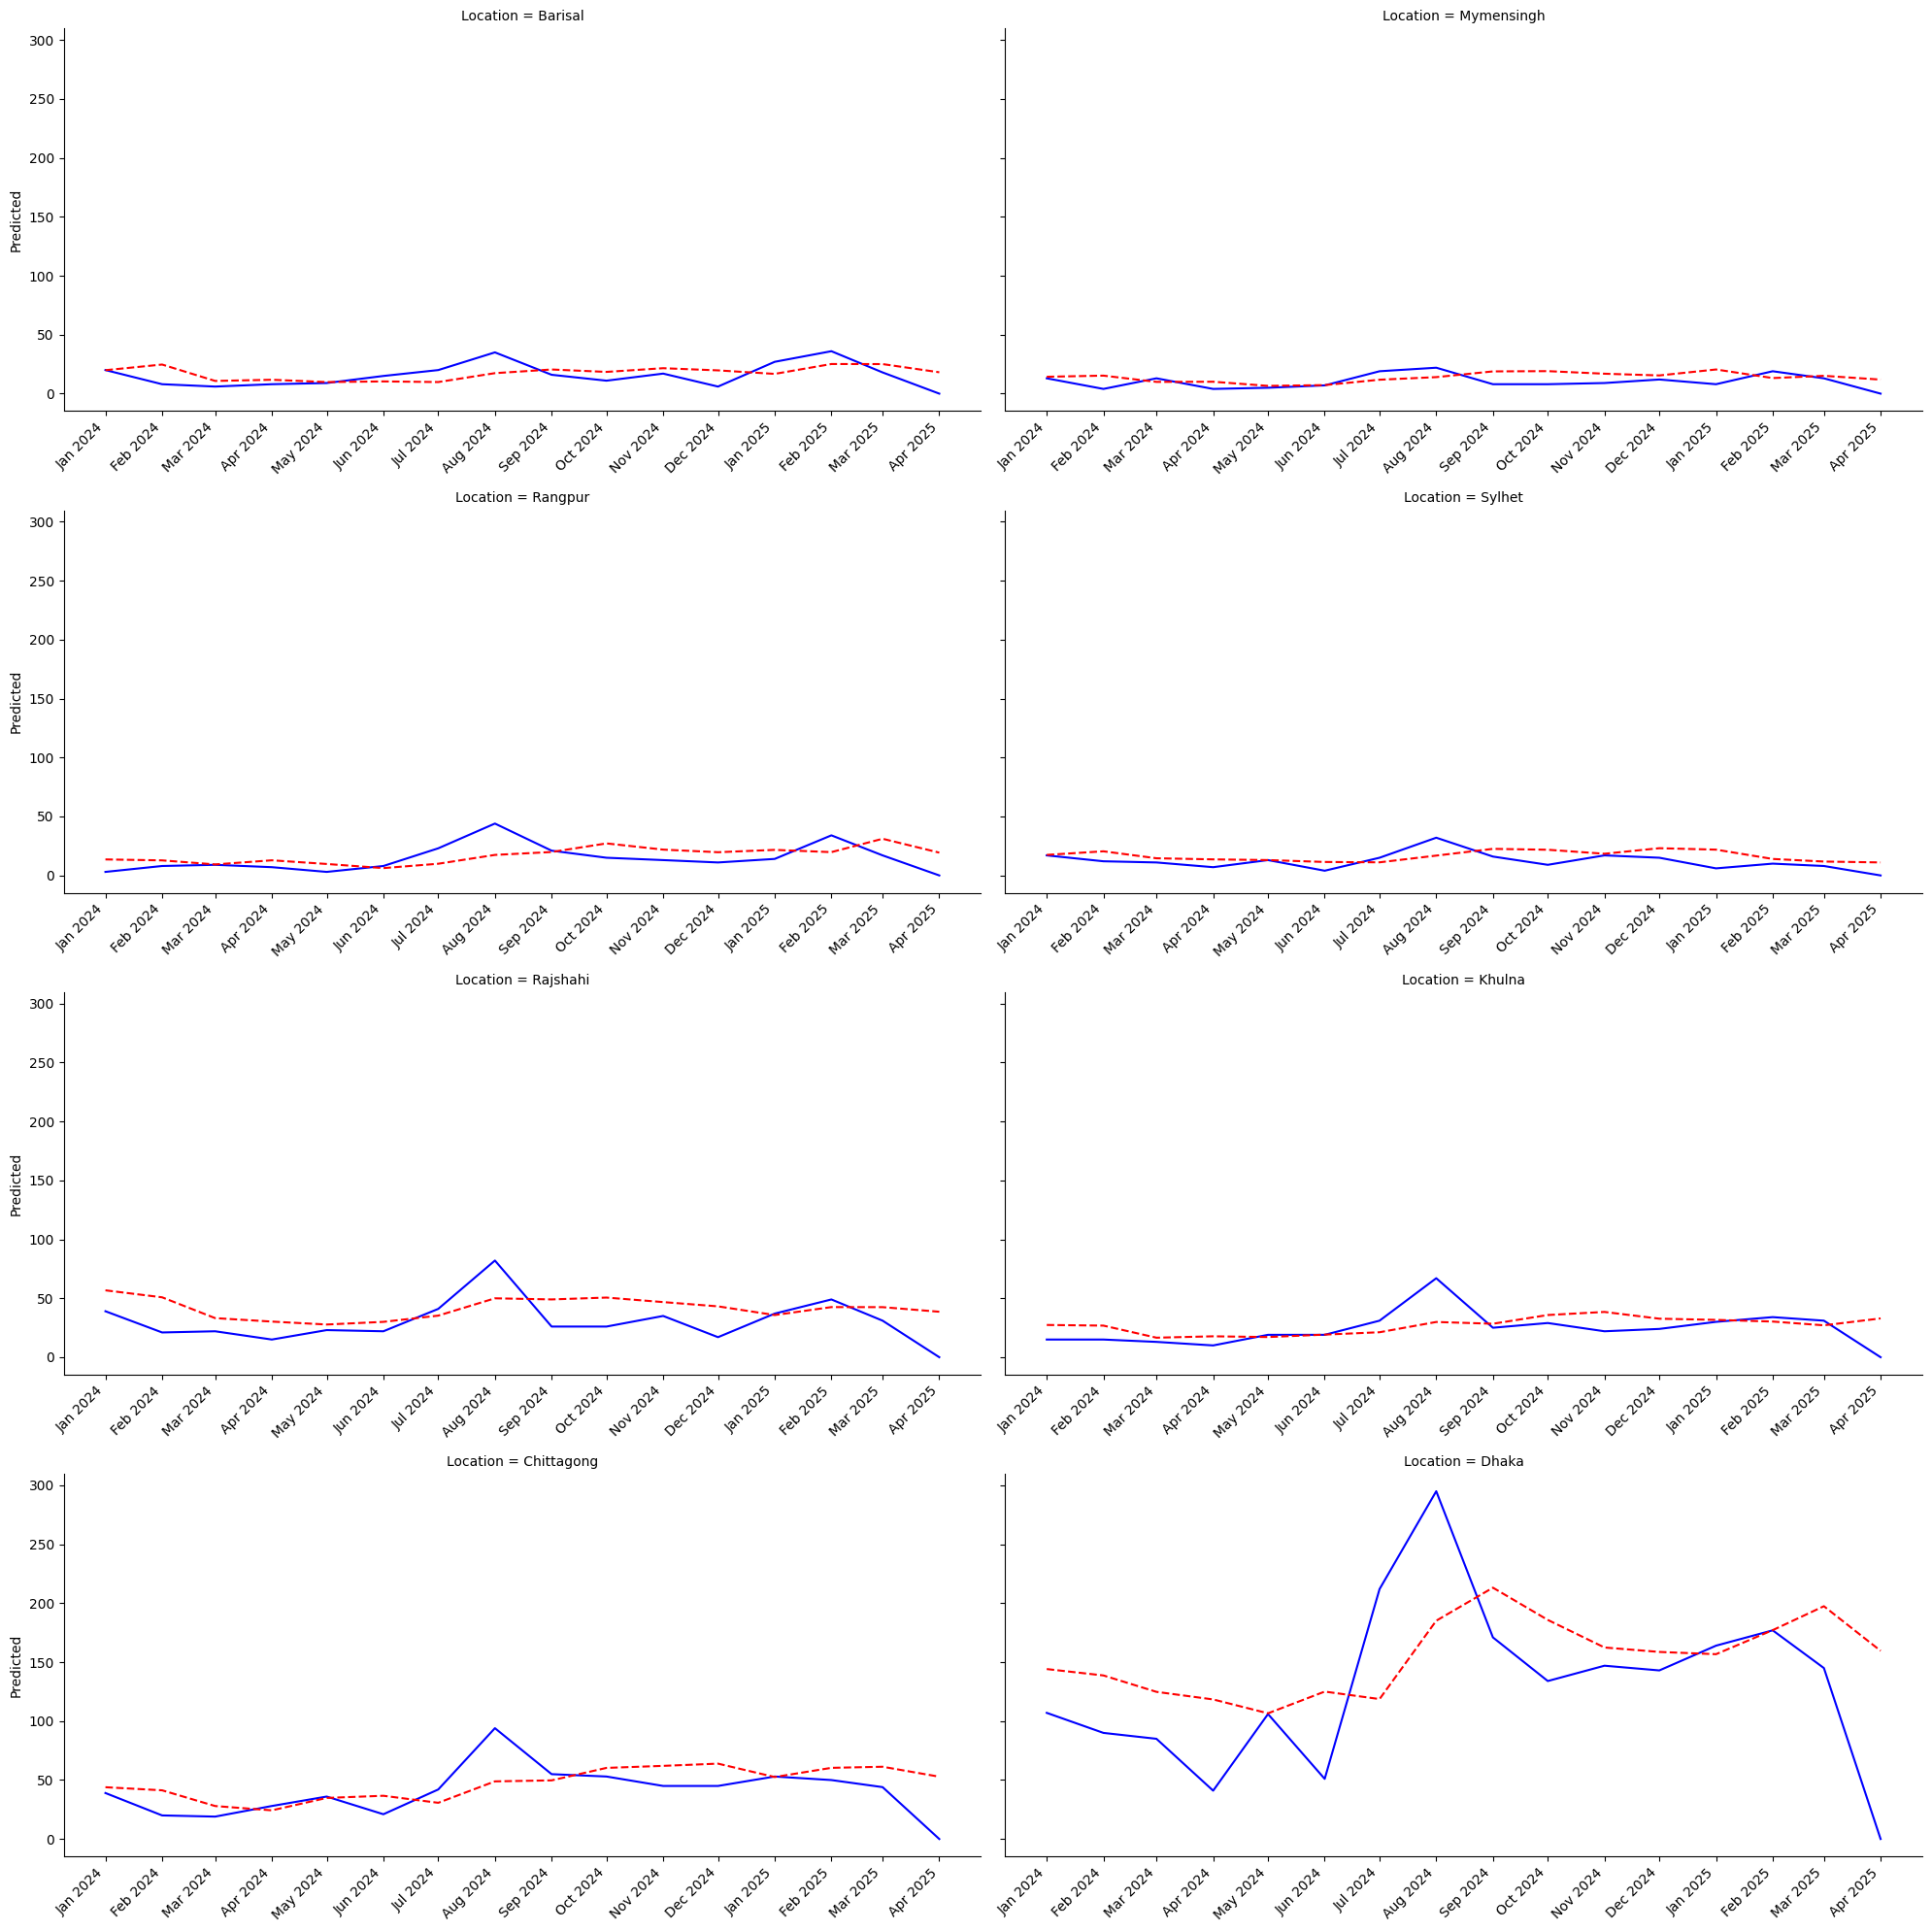

In [ ]:
# results = test.copy()  # Create a copy of the test data
# results["Predicted"] = predictions  # Add predictions column

# # Create FacetGrid with 1 column (vertical stack)
# g = sns.FacetGrid(
#     results,
#     col="Location",
#     col_wrap=2,
#     height=5,
#     aspect=2,
#     sharex=False  # CRITICAL: Each subplot gets its own x-axis
# )

# # 2. Map the plots
# g.map(plt.plot, "Event month", "Total_crimes", label="Actual", color="blue")
# g.map(plt.plot, "Event month", "Predicted", label="Predicted", color="red", linestyle="--")

# # 3. FORCE x-axis labels to appear on all subplots
# for ax in g.axes.flat:
#     # Set proper date formatting
#     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Monthly ticks
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # "Jan 2023" format
    
#     # Make labels visible and rotated
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
#     # Ensure x-axis is fully visible
#     ax.set_xlabel("")
#     ax.xaxis.set_visible(True)

# # 4. Adjust spacing
# plt.subplots_adjust(hspace=0.5)  # Extra vertical space between subplots
# g.figure.tight_layout()

# # 5. Show plot
# plt.show()

# **LSTM model**

In [80]:
def make_windows(df, feat_cols, target_col, date_col, T=3):
    """
    df: sorted DataFrame for one (location, time_bin)
    feat_cols: list of feature names
    target_col: "crime_count"
    date_col: "crime_date"
    T: window length
    Returns X (n_w, T, n_feat), y (n_w,), dates (n_w,)
    """
    data = df[feat_cols + [target_col]].values
    dates = df[date_col].values
    X, y, y_dates = [], [], []
    for i in range(len(data) - T):
        X.append(data[i : i+T, :-1])
        y.append(data[i+T, -1])
        y_dates.append(dates[i+T])         # the date on which the prediction is made
    if not X:
        return (np.zeros((0, T, len(feat_cols))), 
                np.zeros((0,)), 
                np.array([], dtype="datetime64[ns]"))
    return np.stack(X), np.array(y), np.array(y_dates)

In [ ]:
# def make_windows(df, feat_cols, target_col, T):
#     """
#     Input: 
#       df sorted by date for a single (location, time_bin), 
#       feat_cols = list of feature names,
#       target_col = "crime_count"
#     Returns:
#       X : np.array shape (n_windows, T, n_features)
#       y : np.array shape (n_windows,)    (predict next-step count)
#     """
#     data = df[feat_cols + [target_col]].values
#     n = len(data)
#     X, y = [], []
#     for i in range(n - T):
#         X.append(data[i:i+T, :-1])    # all features for T days
#         y.append(data[i+T,  -1])      # target on day T+1
#     return np.stack(X), np.array(y)

# all_X, all_y = [], []
# T = 3  # number of time steps in the window
# for (loc, tr), group in agg.sort_values(["Crime Location","Crime time","Crime date"]).groupby(["Crime Location","Crime time"]):
#     if len(group) <= T:
#         continue
#     Xg, yg = make_windows(
#         group,
#         feat_cols=selected_feats,
#         target_col="crime count",
#         T=T
#     )

#     all_X.append(Xg)
#     all_y.append(yg)

# X = np.concatenate(all_X, axis=0)   # shape = (total_samples, 7, n_features)
# y = np.concatenate(all_y, axis=0)   # shape = (total_samples,)
# print(X.shape, y.shape)
all_X, all_y, all_dates = [], [], []

for _, group in agg.sort_values(["Crime Location","Crime time","Crime date"]).groupby(["Crime Location","Crime time"]):
    Xg, yg, dg = make_windows(
        group,
        feat_cols=feature_cols,
        target_col="crime count",
        date_col="Crime date",
        T=3
    )
    if Xg.shape[0] > 0:
        all_X.append(Xg)
        all_y.append(yg)
        all_dates.append(dg)

# concatenate across all panels
X = np.concatenate(all_X, axis=0)       # shape = (total_windows, 3, n_features)
y = np.concatenate(all_y, axis=0)       # shape = (total_windows,)
dates = np.concatenate(all_dates, axis=0)  # shape = (total_windows,)

In [84]:
cutoff = pd.to_datetime("2024-07-30")  # train ≤ this, test > this

train_mask = dates <= cutoff
test_mask  = dates  > cutoff

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

In [51]:
import tensorflow.keras.backend as K    # type: ignore

def r2_keras(y_true, y_pred):
    # Sum squared residuals
    ss_res = K.sum(K.square(y_true - y_pred))
    # Total sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    # R² = 1 − SS_res/SS_tot
    return 1 - ss_res/(ss_tot + K.epsilon())

In [94]:
n_features = X.shape[2]
T = X.shape[1]

model = Sequential([
    LSTM(
      units=30,
      input_shape=(T, n_features),
      return_sequences=False,
      kernel_regularizer=l2(1e-4),
      recurrent_regularizer=l2(1e-4),
      bias_regularizer=l2(1e-4)
    ),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(1)   # regression output
])

model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["RootMeanSquaredError"]
)

# Train / validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=False)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32
)

Epoch 1/100


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - RootMeanSquaredError: 9.5714 - loss: 92.0012 - val_RootMeanSquaredError: 8.4827 - val_loss: 71.9679
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - RootMeanSquaredError: 8.9506 - loss: 80.1807 - val_RootMeanSquaredError: 8.1631 - val_loss: 66.6475
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - RootMeanSquaredError: 8.3535 - loss: 69.8285 - val_RootMeanSquaredError: 7.8368 - val_loss: 61.4268
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - RootMeanSquaredError: 7.7977 - loss: 61.0994 - val_RootMeanSquaredError: 7.4923 - val_loss: 56.1460
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - RootMeanSquaredError: 8.4773 - loss: 72.2710 - val_RootMeanSquaredError: 7.1162 - val_loss: 50.6526
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - RootMeanSquaredError: 7.8171 - loss: 61.2332 - val_RootMeanSquaredError: 6.6765 - val_loss: 44.5868
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - RootMeanSquaredError: 7.7591 - loss: 60.8220 - v

In [95]:
results = model.evaluate(X_test, y_test, return_dict=True)
print("Test‐window metrics:")
for name, val in results.items():
    print(f"  {name}: {val:.4f}")

y_pred = model.predict(X_test).ravel()
print("Test‐window R²:", r2_score(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - RootMeanSquaredError: 3.6797 - loss: 13.5941
Test‐window metrics:
  RootMeanSquaredError: 3.5424
  loss: 12.5644
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Test‐window R²: 0.5655408231974868


In [104]:
model.save("thesis_model.keras")

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences   # type: ignore
# take the last T days of each group to build a “future” X_pred
raw_seqs, groups, y_true = [], [], []

for name, group in agg.sort_values(
        ["Crime Location","Crime time","Crime date"]
    ).groupby(["Crime Location","Crime time"]):

    # only panels long enough to forecast
    if len(group) < T+1:
        continue

    # last T days → model input
    seq = group[feature_cols].values[-T:]
    raw_seqs.append(seq)
    groups.append(name)

    # the “true” crime_count on day T+1
    y_true.append(group["crime count"].values[-1])

# pad/truncate to shape (n_panels, T, n_features)
X_pred = pad_sequences(
    raw_seqs,
    maxlen=T,
    dtype="float32",
    padding="pre",
    truncating="pre",
    value=0.0
)
# y_pred = model.predict(X_pred)
y_pred = model.predict(X_pred).ravel()

print("forecast RMSE:", root_mean_squared_error(y_true, y_pred))
print("forecast R²:  ", r2_score(y_true, y_pred))

In [ ]:
y_pred = model.predict(X_test).ravel()
print("forecast RMSE:", root_mean_squared_error(y_true, y_pred))
print("forecast R²:  ", r2_score(y_true, y_pred))

In [41]:
pred_df = pd.DataFrame(
    {"location": [g[0] for g in groups],
     "time_range": [g[1] for g in groups],
     "predicted_count": y_pred.ravel()}
)

In [75]:
# final epoch metrics
final = {k: v[-1] for k,v in history.history.items()}
print("Final training metrics:")
for name, val in final.items():
    print(f"  {name}: {val:.4f}")

Final training metrics:
  RootMeanSquaredError: 5.1973
  loss: 27.0198
  r2_keras: -39.6683
  val_RootMeanSquaredError: 4.1587
  val_loss: 17.3029
  val_r2_keras: -51.0026


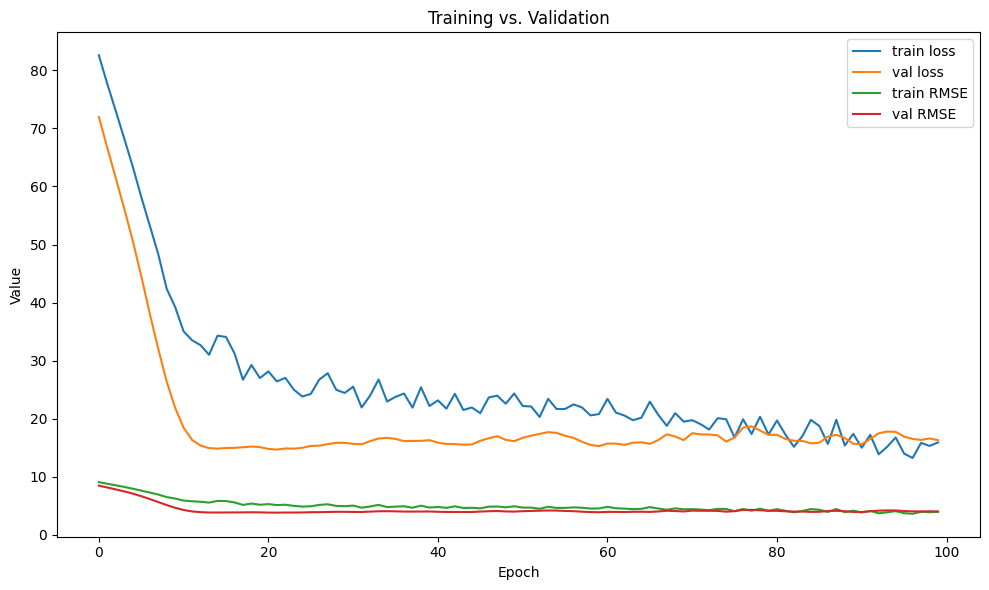

In [96]:
# plot loss and RMSE over epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['RootMeanSquaredError'], label='train RMSE')
plt.plot(history.history['val_RootMeanSquaredError'], label='val RMSE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training vs. Validation')
plt.tight_layout()
plt.show()

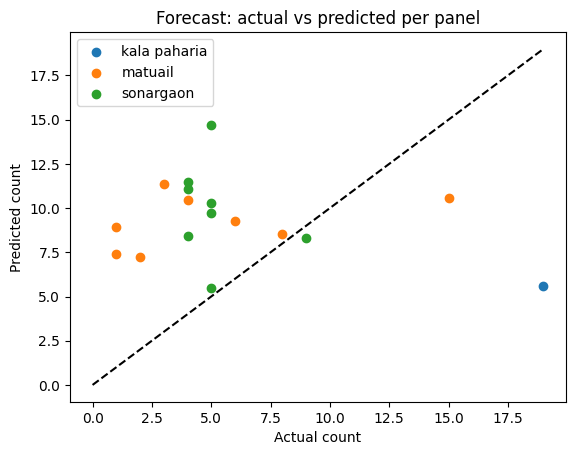

In [97]:
pred_df = pd.DataFrame([
    {"location": loc, "time_range": tr, "actual": a, "pred": p}
    for (loc,tr), a, p in zip(groups, y_true, y_pred)
])

# e.g. bar-plot or scatter by location:
for loc, sub in pred_df.groupby("location"):
    plt.scatter(sub["actual"], sub["pred"], label=loc)
plt.plot([0, max(pred_df.actual.max(),pred_df.pred.max())],
         [0, max(pred_df.actual.max(),pred_df.pred.max())],
         linestyle="--", color="k")
plt.xlabel("Actual count")
plt.ylabel("Predicted count")
plt.legend()
plt.title("Forecast: actual vs predicted per panel")
plt.show()

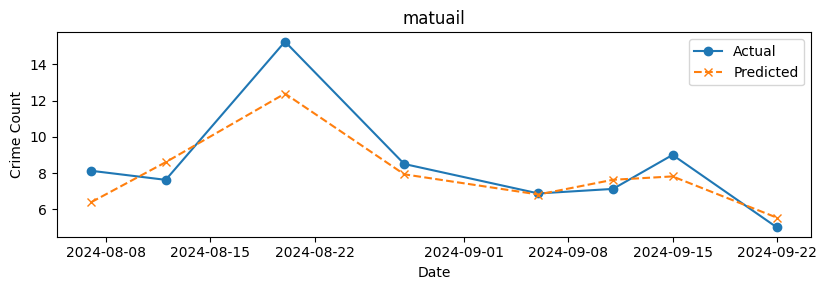

In [103]:
T = 3
samples = []
for (loc, tr), group in agg.sort_values(["Crime Location","Crime time","Crime date"]).groupby(["Crime Location","Crime time"]):
    # get sliding windows, targets and dates
    Xg, yg, dg = make_windows(
        group,
        feat_cols=feature_cols,
        target_col="crime count",
        date_col="Crime date",
        T=T
    )
    # for each window, record a row
    for i in range(len(yg)):
        samples.append({
            "location":    loc,
            "time_range":  tr,
            "crime_date":  dg[i],    # the date being predicted
            "actual":      yg[i],
            "X_window":    Xg[i]     # shape (T, n_features)
        })

df_win = pd.DataFrame(samples)
df_win["crime_date"] = pd.to_datetime(df_win["crime_date"])
test_mask = df_win["crime_date"] > cutoff

X_test = np.stack(df_win.loc[test_mask, "X_window"].values)
y_test = df_win.loc[test_mask, "actual"].values
dates  = df_win.loc[test_mask, "crime_date"]
locs   = df_win.loc[test_mask, "location"]

df_plot = pd.DataFrame({
    "crime_date": dates,
    "location":   locs,
    "actual":     y_test,
    "predicted":  y_pred
})

pivot_actual_2 = df_plot.pivot_table(index="crime_date", columns="location", values="actual", aggfunc="mean").fillna(0)
pivot_pred_2   = df_plot.pivot_table(index="crime_date", columns="location", values="predicted", aggfunc="mean").fillna(0)

locations = pivot_actual_2.columns.tolist()
rows = int(np.ceil(len(locations)/3))
fig, axes = plt.subplots(rows, 3, figsize=(24, rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, loc in zip(axes, locations):
    ax.plot(pivot_actual_2.index, pivot_actual_2[loc], marker="o", label="Actual")
    ax.plot(pivot_pred_2.index,   pivot_pred_2[loc], marker="x", linestyle="--", label="Predicted")
    ax.set_title(loc)
    ax.set_xlabel("Date")
    ax.set_ylabel("Crime Count")
    ax.legend()

# hide any unused axes
for ax in axes[len(locations):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [70]:
keras.backend.clear_session()

In [ ]:
# le = LabelEncoder()
# df_wide["Location_Encoded"] = le.fit_transform(df_wide["Location"])

In [ ]:
# import joblib

# temporal_features = features
# scaler = MinMaxScaler()
# df_wide[temporal_features] = scaler.fit_transform(df_wide[temporal_features])
# joblib.dump(scaler, 'lstm_model_scaler.joblib')

['lstm_model_scaler.joblib']

In [ ]:
# def create_sequences(data, look_back):
#     X_temp, X_city, y = [], [], []
#     dates, cities = [], []  # New: Track dates and cities for each sequence
#     cities_unique = data["Location_Encoded"].unique()
    
#     for city in cities_unique:
#         city_data = data[data["Location_Encoded"] == city].sort_values("Event month")
#         for i in range(len(city_data) - look_back):
#             # Append features and targets
#             X_temp.append(city_data[temporal_features].values[i:i+look_back])
#             X_city.append(city_data["Location_Encoded"].values[i+look_back])
#             y.append(city_data["Total_crimes"].values[i+look_back])
            
#             # Track metadata for the TARGET time step (i+look_back)
#             dates.append(city_data["Event month"].iloc[i+look_back])  # Date of the target
#             cities.append(city_data["Location"].iloc[i+look_back])  # City name
    
#     return np.array(X_temp), np.array(X_city), np.array(y), dates, cities

# X_temp, X_city, y, dates, cities = create_sequences(df_wide, look_back=12)

In [ ]:
# # Inputs
# look_back = 12
# temp_input = Input(shape=(look_back, len(temporal_features)), name="temp_input")  # (None, 12, 5)
# city_input = Input(shape=(1,), name="city_input")                                 # (None, 1)

# # City Embedding (learns dense representations for cities)
# num_cities = len(df_wide["Location_Encoded"].unique())
# embedding = Embedding(input_dim=num_cities, output_dim=4)(city_input)  # Output shape: (None, 1, 4)
# embedding_reshaped = Reshape((4,))(embedding)
# embedding_rep = RepeatVector(look_back)(embedding_reshaped)            # (None, 12, 4)

# # Concatenate temporal features and city embeddings
# combined = Concatenate(axis=-1)([temp_input, embedding_rep])         # (None, 12, 5+4=9)

# # LSTM Layers
# lstm_out = LSTM(50, activation="relu")(combined)
# output = Dense(1)(lstm_out)  # Predict total crimes (adjust for multi-output)

# # Compile
# model = Model(inputs=[temp_input, city_input], outputs=output)
# optimizer = keras.optimizers.Adam(learning_rate=0.0002)
# model.compile(optimizer=optimizer, loss="mse")

In [ ]:
# print(num_cities)

8


### **Training and Evaluation**

In [ ]:
# split = int(0.7 * len(X_temp))
# X_temp_train, X_temp_test = X_temp[:split], X_temp[split:]
# X_city_train, X_city_test = X_city[:split], X_city[split:]
# y_train, y_test = y[:split], y[split:]

# dates_test = dates[split:]
# cities_test = cities[split:]

In [ ]:
# print("X_temp_train shape:", X_temp_train.shape)  # Should be (samples, 12, num_features)
# print("X_city_train shape:", X_city_train.shape)  # Should be (samples,)
# assert X_temp_train.shape[1] == look_back
# # assert X_temp_train.shape[2] == len(selected_features)

X_temp_train shape: (425, 12, 14)
X_city_train shape: (425,)


In [ ]:
# test = pd.DataFrame({
#     "Date": dates_test,
#     "City": cities_test,
#     "Total_Crimes": y_test  # Actual crime counts
# })

In [ ]:
# # Ensure correct data types for training
# X_temp_train = X_temp_train.astype('float32')
# X_city_train = X_city_train.astype('int32')
# y_train = y_train.astype('float32')

# # Ensure correct data types for validation (important!)
# X_temp_test = X_temp_test.astype('float32')
# X_city_test = X_city_test.astype('int32')
# y_test = y_test.astype('float32')

In [ ]:
# history = model.fit(
#     [X_temp_train, X_city_train], 
#     y_train,
#     epochs=50,
#     batch_size=32,
#     validation_data=([X_temp_test, X_city_test], y_test)
# )

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 232.8634 - val_loss: 4703.2720
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 281.2876 - val_loss: 4693.4141
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 248.2236 - val_loss: 4682.3945
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 251.7024 - val_loss: 4667.4072
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 248.9269 - val_loss: 4644.6274
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 238.5831 - val_loss: 4601.3257
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 229.0702 - val_loss: 4477.9233
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 248.0717 - val_loss: 3756.5696
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 210.0152 - val_loss: 2120.0591
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 145.9700 - val_loss: 2044.3430
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 122.9832 - val_loss: 1788.0060
Epoch 12/50
14/14

In [32]:
from tensorflow.keras.models import load_model # type: ignore

# Load the model architecture + weights
model = load_model(r'F:\University\Uni Stuff (semester 11)\Thesis\code\notebook\ACLED_model.keras')  # or .keras

In [33]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ city_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 4)      │         32 │ city_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temp_input          │ (None, 12, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 12, 4)     │          0 │ reshape[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 18)    │          0 │ temp_input[0][0], │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50)        │     13,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         51 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,651 (162.70 KB)

 Trainable params: 13,883 (54.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,768 (108.47 KB)

In [ ]:
# # Predict
# y_pred = model.predict([X_temp_test, X_city_test])

# # Metrics
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)
# print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
MAE: 15.94, RMSE: 27.10, R²: 0.64


In [ ]:
# # Fix city input
# city_fixed = np.array([0])  # Replace with city encoding

# # Define prediction function for temporal features only
# def temporal_predict(X_temp_flat):
#     """Reshape flattened temporal features and pair with fixed city"""
#     X_temp = X_temp_flat.reshape(-1, look_back, len(temporal_features))
#     return model.predict([X_temp, np.repeat(city_fixed, len(X_temp))])

# # Prepare background data (flattened temporal features)
# background_temporal = X_temp_train[:50].reshape(50, -1)

# # Initialize KernelExplainer
# explainer = shap.KernelExplainer(
#     temporal_predict,
#     background_temporal,
#     link="identity"  # For regression tasks
# )

# # Compute SHAP values for a test instance
# test_instance_flat = X_temp_test[0].flatten()
# shap_values = explainer.shap_values(test_instance_flat)

# # Get feature names for time steps
# feature_names = [
#     f"{feat}_t-{i}" 
#     for i in range(look_back, 0, -1)  # t-12 to t-1
#     for feat in temporal_features
# ]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [ ]:
# # Compare SHAP values for different cities
# for city_id in [0, 1, 2]:
#     city_fixed = np.array([city_id])
#     shap_values = explainer.shap_values(test_instance_flat)
#     print(f"City {city_id} - Baseline: {explainer.expected_value[0]:.1f}, SHAP Sum: {np.sum(shap_values):.1f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
City 0 - Baseline: 11.7, SHAP Sum: 11.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
City 1 - Baseline: 11.7, SHAP Sum: 11.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
City 2 - Baseline: 11.7, SHAP Sum: 31.1


In [ ]:
# for city_fixed in [0, 1, 2, 3, 4 , 5, 6, 7]:
#     city_decoded = le.inverse_transform([city_fixed])
#     print(f"City ID {city_fixed} corresponds to {city_decoded[0]}")

City ID 0 corresponds to Barisal
City ID 1 corresponds to Chittagong
City ID 2 corresponds to Dhaka
City ID 3 corresponds to Khulna
City ID 4 corresponds to Mymensingh
City ID 5 corresponds to Rajshahi
City ID 6 corresponds to Rangpur
City ID 7 corresponds to Sylhet


### **Plotting**

In [38]:
model.save("ACLED_model.keras")

In [ ]:
# # Add predictions to the test DataFrame
# test["Predicted"] = y_pred

# # Now `results` is ready for visualization
# results = test.copy()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_688\3288721192.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_

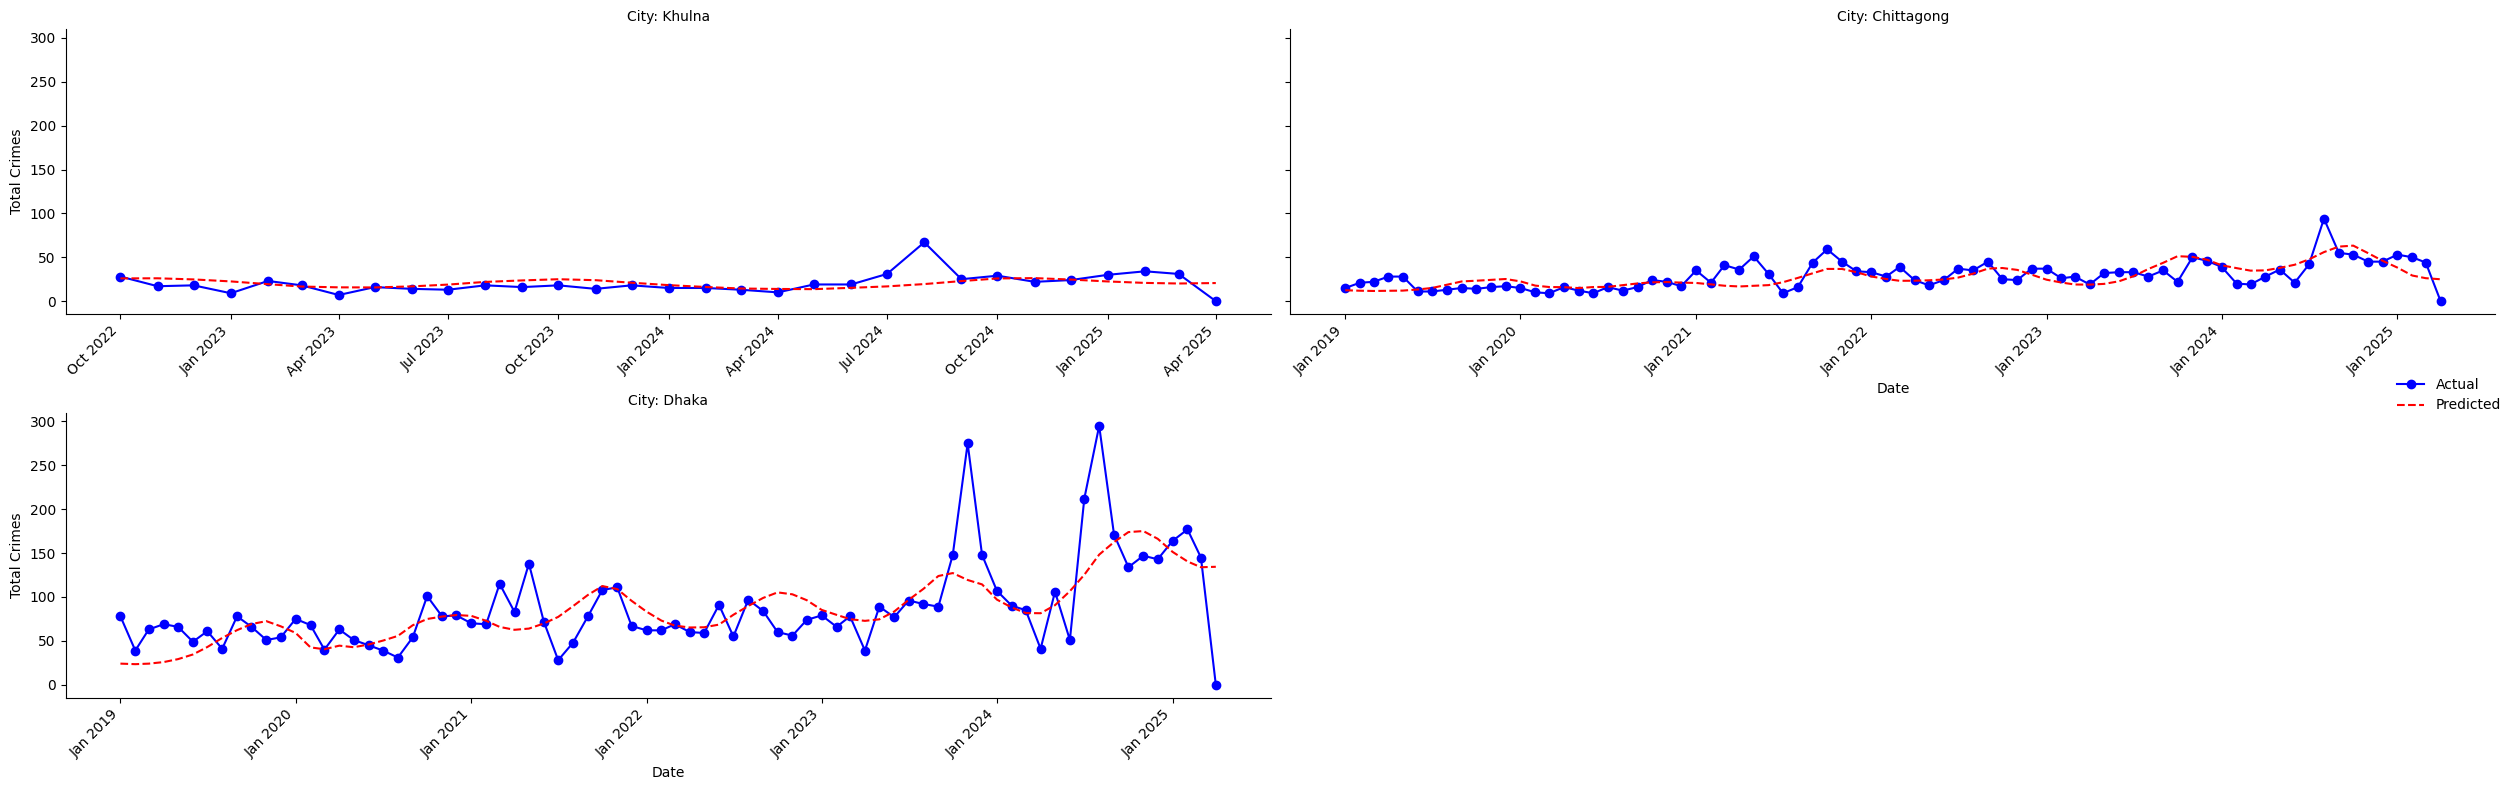

In [ ]:
# # 1. Initialize the FacetGrid
# g = sns.FacetGrid(
#     results, 
#     col="City",               # Split by city
#     col_wrap=2,               # Number of columns in the grid
#     height=4,                 # Height of each subplot
#     aspect=3,                 # Width-to-height ratio
#     sharex=False,             # Each subplot has its own x-axis
#     # sharey=False              # Each subplot has its own y-axis
# )

# # 2. Map actual and predicted values to each subplot
# g.map(plt.plot, "Date", "Total_Crimes", label="Actual", color="blue", marker="o")
# g.map(plt.plot, "Date", "Predicted", label="Predicted", color="red", linestyle="--")

# # 3. Customize labels and formatting
# g.set_axis_labels("Date", "Total Crimes")
# g.set_titles("City: {col_name}")  # Subplot titles
# g.add_legend()                    # Show legend for all subplots

# # 4. Format x-axis dates
# for ax in g.axes.flat:
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format dates as "YYYY-MM"
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right")      # Rotate x-labels

# # 5. Adjust layout and display
# plt.tight_layout()
# plt.show()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


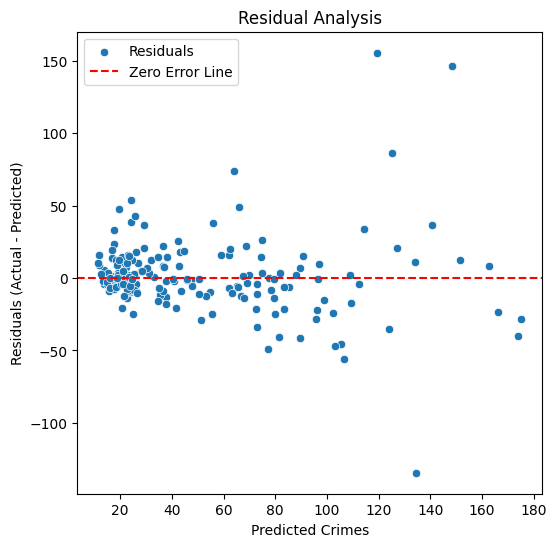

In [ ]:
# residuals = results["Total_Crimes"] - results["Predicted"]

# plt.figure(figsize=(6, 6))
# # Scatter plot with legend label
# sns.scatterplot(x=results["Predicted"], y=residuals, label='Residuals')
# # Horizontal line with legend label
# plt.axhline(y=0, color="r", linestyle="--", label='Zero Error Line')

# plt.xlabel("Predicted Crimes")
# plt.ylabel("Residuals (Actual - Predicted)")
# plt.title("Residual Analysis")
# plt.legend()  # Activate the legend
# plt.show()

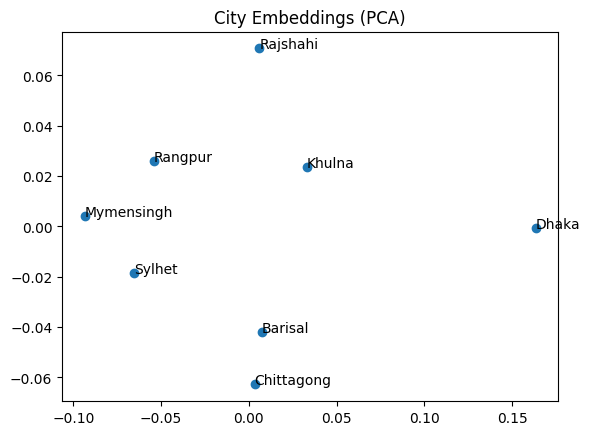

In [ ]:
# # Get embedding weights
# embedding_weights = model.get_layer("embedding").get_weights()[0]

# # Visualize (PCA to 2D)
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(embedding_weights)

# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# for i, city in enumerate(le.classes_):
#     plt.annotate(city, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
# plt.title("City Embeddings (PCA)")
# plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_688\3180115842.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent overlap


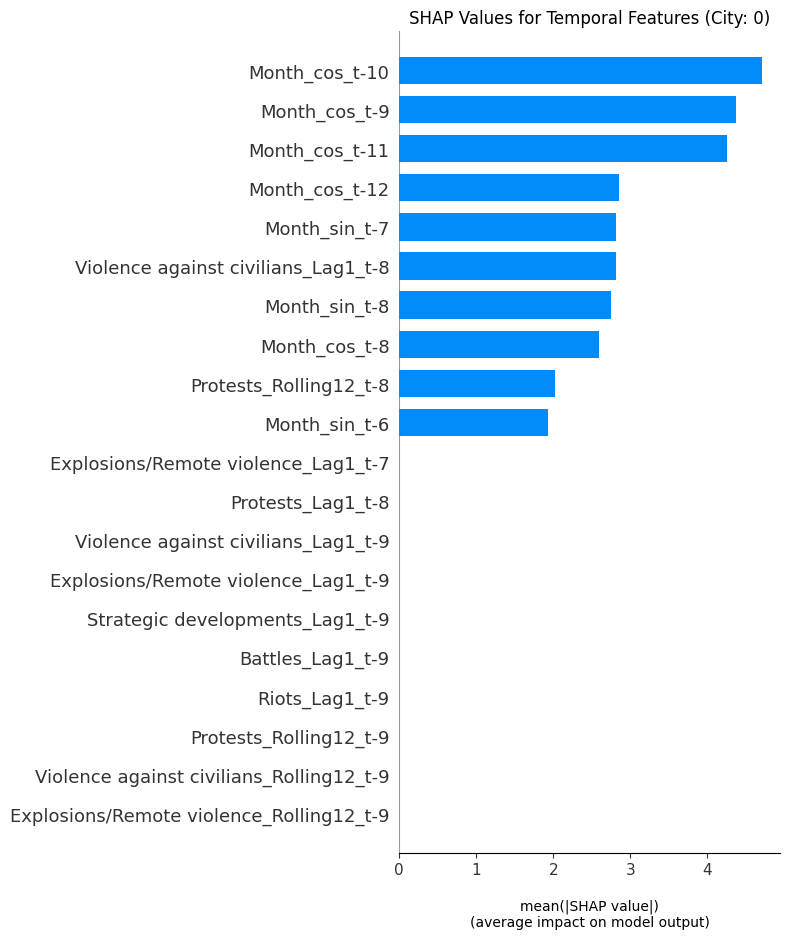

In [ ]:
# plt.figure(figsize=(14, 8))
# shap.summary_plot(
#     np.array(shap_values).reshape(1, -1),  # Reshape for single sample
#     feature_names=feature_names,
#     plot_type="bar",
#     show=False
# )

# city_fixed = np.array([0])
# plt.xlabel("mean(|SHAP value|)\n(average impact on model output)", 
#           fontsize=10,  # Smaller font
#           labelpad=15)
# plt.title(f"SHAP Values for Temporal Features (City: {city_fixed[0]})")
# plt.subplots_adjust(bottom=0.3)
# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:753: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


<Figure size 640x480 with 0 Axes>

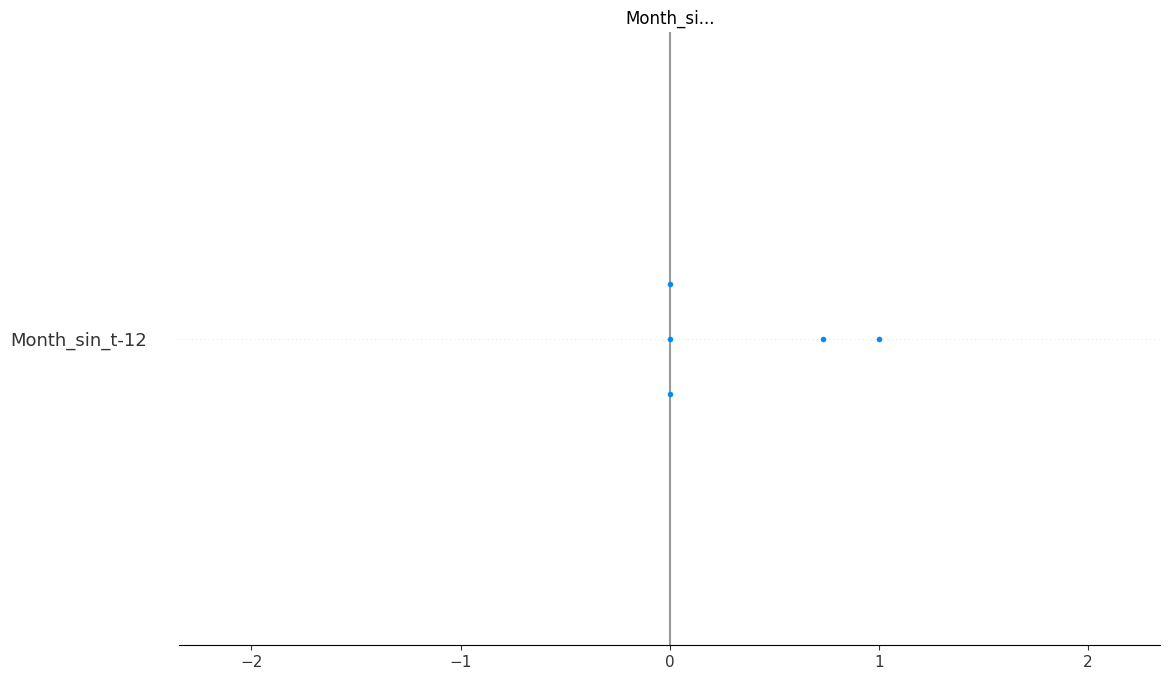

In [ ]:
# # Compute SHAP values for multiple test samples
# samples_to_explain = 5
# shap_values_multi = np.array([
#     explainer.shap_values(X_temp_test[i].flatten())
#     for i in range(samples_to_explain)
# ])

# shap.summary_plot(
#     shap_values_multi,
#     feature_names=feature_names,
#     plot_type="dot"
# )